<a href="https://colab.research.google.com/github/tejaspradhan/Graph-Neural-Networks/blob/main/emotion-analysis-gnn/EA_Tweets_Dataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U tf_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 2.8 MB/s 
  Created wheel for tf-geometric: filename=tf_geometric-0.0.85-py3-none-any.whl size=83363 sha256=d70d88d315afba7a1c3087238b1855db147ed8aa49a0c68f7d3f92e78098de80
  Stored in directory: /root/.cache/pip/wheels/69/52/e3/73712d9cc745cef103f1c8af7227b2cd6d85afc872d683c777
  Created wheel for ogb-lite: filename=ogb_lite-0.0.3-py3-none-any.whl size=33524 sha256=747cce7807dc4ef6d92c687882d5be9020fec04d1561e9f70ca2a01d3a3c006d
  Stored in directory: /root/.cache/pip/wheels/bb/98/b1/5d034ba69940a93aa9b8e05f6e2f630f47b045209bc3cfa210
  Created wheel for tf-sparse: filename=tf_sparse-0.0.12-py3-none-any.whl size=8620 sha256=a842eb7e04570756bbacbe9499ab47831df09f69d6f4a503b1e3c487b412912f
  Stored in directory: /root/.cache/pip/wheels/2e/41/8f/1e133789167b6af81bb69db1407b7cd05f1d68061f581d8142
  Created wheel for littleutils: filename=littleuti

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from tf_geometric.utils import tf_utils

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# # In case of any corpus are missing 
# download all-nltk
nltk.download('stopwords')
stop_words = stopwords.words("english")

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
import tensorflow as tf
import tf_geometric as tfg
import pickle
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Downloading and Exploring Data

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle datasets download -d subhajournal/tweet-sentiment-and-emotion-analysis

  0% 0.00/269k [00:00<?, ?B/s]
100% 269k/269k [00:00<00:00, 52.3MB/s]


In [7]:
!unzip /content/tweet-sentiment-and-emotion-analysis.zip

Archive:  /content/tweet-sentiment-and-emotion-analysis.zip
  inflating: all_tweets.csv          


In [8]:
data = pd.read_csv('/content/all_tweets.csv')

In [9]:
data.shape

(6032, 5)

In [10]:
data.head()

,Unnamed: 0,sentiment,text,user,label
0,0,positive,RT @SchudioTv: Want to know more about #autism...,beyondbehaviour,anxiety
1,1,negative,We blame ourselves and feel worse. Start with ...,cherie7c,anxiety
2,2,positive,"RT @PsychiatristCNS: 130,000 patient years and...",ThinkNeha,anxiety
3,3,neutral,RT @SkypeTherapist: See a therapist online ove...,FrankCoulson7,anxiety
4,4,positive,"RT @PsychiatristCNS: 130,000 patient years and...",Phcourtet,anxiety


In [11]:
data.isna().sum()

Unnamed: 0    0
sentiment     0
text          0
user          0
label         0
dtype: int64

In [12]:
data.columns

Index(['Unnamed: 0', 'sentiment', 'text', 'user', 'label'], dtype='object')

In [13]:
data.drop(['Unnamed: 0','user'],axis=1,inplace=True)

In [14]:
data.head()

,sentiment,text,label
0,positive,RT @SchudioTv: Want to know more about #autism...,anxiety
1,negative,We blame ourselves and feel worse. Start with ...,anxiety
2,positive,"RT @PsychiatristCNS: 130,000 patient years and...",anxiety
3,neutral,RT @SkypeTherapist: See a therapist online ove...,anxiety
4,positive,"RT @PsychiatristCNS: 130,000 patient years and...",anxiety


In [15]:
set(data['label']). # 4 unique emotions 

{'anxiety', 'depression', 'happy', 'stress'}

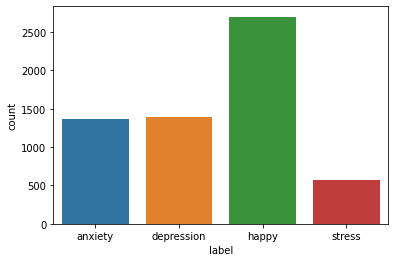

In [34]:
sns.countplot(x='label',data=data)

## Data Preprocessing

In [21]:
def clean_text(x):
  x = x.lower()
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  x = re.sub('rt','',x)
  return x

In [22]:
data['text'] = data['text'].apply(clean_text)

In [24]:
data['text'][0]

' want know watch sho clip n nclick enrol '

In [35]:
texts = data['text']
print(texts.shape)
labels = data['label']
print(labels.shape)

(6032,)
(6032,)


In [36]:
train_texts,test_texts,train_labels,test_labels = train_test_split(texts,labels)

In [37]:
print(train_texts.shape)
print(test_texts.shape)
print(train_labels.shape)
print(test_labels.shape)


(4524,)
(1508,)
(4524,)
(1508,)


#### Label Encoding

In [42]:
from sklearn.preprocessing import LabelEncoder
encoder =LabelEncoder()

In [43]:
train_labels= encoder.fit_transform(train_labels)
test_labels = encoder.transform(test_labels)

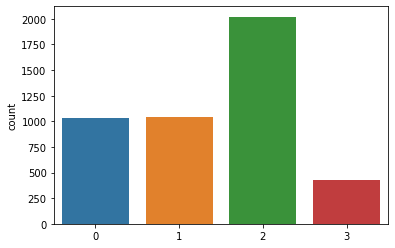

In [48]:
sns.countplot(x=train_labels)

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [50]:
class PMIModel(object):

    def __init__(self):
        self.word_counter = None
        self.pair_counter = None

    def get_pair_id(self, word0, word1):
        pair_id = tuple(sorted([word0, word1]))
        return pair_id

    def fit(self, sequences, window_size):

        self.word_counter = Counter()
        self.pair_counter = Counter()
        num_windows = 0
        for sequence in tqdm(sequences):
            for offset in range(len(sequence) - window_size):
                window = sequence[offset:offset + window_size]
                num_windows += 1
                for i, word0 in enumerate(window):
                    self.word_counter[word0] += 1
                    for j, word1 in enumerate(window[i + 1:]):
                        pair_id = self.get_pair_id(word0, word1)
                        self.pair_counter[pair_id] += 1

        for word, count in self.word_counter.items():
            self.word_counter[word] = count / num_windows
        for pair_id, count in self.pair_counter.items():
            self.pair_counter[pair_id] = count / num_windows

    def transform(self, word0, word1):
        prob_a = self.word_counter[word0]
        prob_b = self.word_counter[word1]
        pair_id = self.get_pair_id(word0, word1)
        prob_pair = self.pair_counter[pair_id]

        if prob_a == 0 or prob_b == 0 or prob_pair == 0:
           return 0

        pmi = np.log(prob_pair / (prob_a * prob_b))
        # print(word0, word1, pmi)
        pmi = np.maximum(pmi, 0.0)
        # print(pmi)
        return pmi

In [51]:
def build_word_graph(num_words, pmi_model, embedding_size):
    x = tf.Variable(tf.random.truncated_normal([num_words, embedding_size], stddev=1 / np.sqrt(embedding_size)),
                    dtype=tf.float32)
    edges = []
    edge_weight = []
    for (word0, word1) in pmi_model.pair_counter.keys():
        pmi = pmi_model.transform(word0, word1)
        if pmi > 0:
            edges.append([word0, word1])
            edge_weight.append(pmi)
            edges.append([word1, word0])
            edge_weight.append(pmi)
    edge_index = np.array(edges).T
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)

In [52]:
def build_combined_graph(word_graph, sequences, embedding_size):
    num_words = word_graph.num_nodes
    x = tf.zeros([len(sequences), embedding_size], dtype=tf.float32)
    edges = []
    edge_weight = []
    for i, sequence in enumerate(sequences):
        doc_node_index = num_words + i
        for word in sequence:
            edges.append([doc_node_index, word])  # only directed edge
            edge_weight.append(1.0)  # use BOW instaead of TF-IDF

    edge_index = np.array(edges).T
    x = tf.concat([word_graph.x, x], axis=0)
    edge_index = np.concatenate([word_graph.edge_index, edge_index], axis=1)
    edge_weight = np.concatenate([word_graph.edge_weight, edge_weight], axis=0)
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)

In [53]:
pmi_cache_path = "cached_pmi_model.p"
if os.path.exists(pmi_cache_path):
    with open(pmi_cache_path, "rb") as f:
        pmi_model = pickle.load(f)
else:
    pmi_model = PMIModel()
    pmi_model.fit(train_sequences, window_size=6)
    with open(pmi_cache_path, "wb") as f:
        pickle.dump(pmi_model, f)

embedding_size = 150
num_words = len(tokenizer.word_index) + 1
word_graph = build_word_graph(num_words, pmi_model, embedding_size)
train_combined_graph = build_combined_graph(word_graph, train_sequences, embedding_size)
test_combined_graph = build_combined_graph(word_graph, test_sequences, embedding_size)

print(word_graph)
print(train_combined_graph)
print(test_combined_graph)

num_classes =4

100%|██████████| 4524/4524 [00:00<00:00, 4780.32it/s]


Graph Shape: x => (6125, 150)	edge_index => (2, 68444)	y => None
Graph Shape: x => (10649, 150)	edge_index => (2, 101797)	y => None
Graph Shape: x => (7633, 150)	edge_index => (2, 78611)	y => None


In [54]:
class GCNModel(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(100, activation=tf.nn.relu)
        self.gcn1 = tfg.layers.GCN(50, activation=tf.nn.relu)
        self.gcn2 = tfg.layers.GCN(num_classes)
        self.dropout = keras.layers.Dropout(0.5)

    def call(self, inputs, training=None, mask=None, cache=None):
        x, edge_index, edge_weight = inputs
        h = self.gcn0([x, edge_index, edge_weight], cache=cache)
        h = self.dropout(h, training=training)
        h = self.gcn1([h, edge_index, edge_weight], cache=cache)
        h = self.gcn2([h, edge_index, edge_weight], cache=cache)
        return h

In [55]:
model = GCNModel()
model.gcn0.cache_normed_edge(train_combined_graph)
model.gcn0.cache_normed_edge(test_combined_graph)

/usr/local/lib/python3.7/dist-packages/tf_geometric/layers/conv/gcn.py:79: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/tf_geometric/layers/conv/gcn.py:79: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)


In [56]:
@tf_utils.function
def forward(graph, training=False):
    logits = model([graph.x, graph.edge_index, graph.edge_weight], cache=graph.cache, training=training)
    logits = logits[num_words:]
    return logits

In [57]:
def compute_loss(logits, labels):
    losses = tf.nn.softmax_cross_entropy_with_logits(
        logits=logits,
        labels=tf.one_hot(labels,depth=num_classes)
    )
    mean_loss = tf.reduce_mean(losses)
    return mean_loss

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

In [61]:
train_losses, train_accs, test_losses, test_accs= [],[],[],[]
for step in range(5000):
    with tf.GradientTape() as tape:
        logits = forward(train_combined_graph, training=True)
        # print("logits" ,logits[0],"Shape",logits[0].shape)
        mean_loss = compute_loss(logits, train_labels)

    vars = tape.watched_variables()
    grads = tape.gradient(mean_loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    if step % 10 == 0:
        # train accuracytf.one_hot(labels, depth=num_classes)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, train_labels), tf.float32)
        train_accuracy = tf.reduce_mean(corrects)
        train_accs.append(train_accuracy)
        train_losses.append(mean_loss)

        logits = forward(test_combined_graph)
        test_loss = compute_loss(logits, test_labels)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, test_labels), tf.float32)
        accuracy = tf.reduce_mean(corrects)
        test_accs.append(accuracy)
        test_losses.append(test_loss)
        print("step = {}\tloss = {}\ttrain_accuracy = {}\ttest_accuracy = {}".format(step, mean_loss, train_accuracy,accuracy))

step = 0	loss = 1.3243070840835571	train_accuracy = 0.44319185614585876	test_accuracy = 0.3812997341156006
step = 10	loss = 1.2105227708816528	train_accuracy = 0.4593280255794525	test_accuracy = 0.4714854061603546
step = 20	loss = 1.0710643529891968	train_accuracy = 0.5072944164276123	test_accuracy = 0.49602121114730835
step = 30	loss = 0.9815978407859802	train_accuracy = 0.5386825799942017	test_accuracy = 0.511273205280304
step = 40	loss = 0.8995745778083801	train_accuracy = 0.6127321124076843	test_accuracy = 0.568965494632721
step = 50	loss = 0.8152523040771484	train_accuracy = 0.6363837122917175	test_accuracy = 0.5557029247283936
step = 60	loss = 0.7911531925201416	train_accuracy = 0.6564986705780029	test_accuracy = 0.5809018611907959
step = 70	loss = 0.7235138416290283	train_accuracy = 0.6772767305374146	test_accuracy = 0.6034482717514038
step = 80	loss = 0.717804491519928	train_accuracy = 0.7011494040489197	test_accuracy = 0.6193633675575256
step = 90	loss = 0.6982749700546265	tra

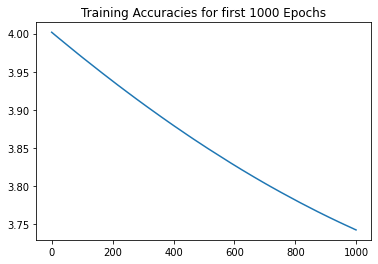

In [ ]:
plt.plot(range(len(train_losses)),train_losses)
plt.title("Training Losses for first 1000 Epochs")
plt.show()

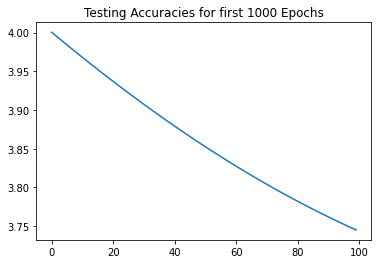

In [ ]:
plt.plot(range(len(test_losses)),test_losses)
plt.title("Testing Losses for first 1000 Epochs")
plt.show()